In [1]:
## importing data
import pandas as pd   
import numpy as np    
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt  
%matplotlib inline

In [ ]:
#### credits: 
# https://github.com/manvendra7/CARD-FRAUD-DETECTION/blob/master/IEE_CIS_EDA_AND_MODELS.ipynb
# https://medium.com/@gtavicecity581/ieee-fraud-detection-469398ce1ac4 // https://github.com/KaustuvDash/IEEE-Fraud-Detection

In [ ]:
#### Merging identity and transaction dataset
# credits: https://github.com/manvendra7/CARD-FRAUD-DETECTION/blob/master/IEE_CIS_EDA_AND_MODELS.ipynb

identity = pd.read_csv('Data/ieee/train_identity.csv')  #downloaded from kaggle
transaction = pd.read_csv('Data/ieee/train_transaction.csv')   #downloaded from kaggle

print(f'identity has {identity.shape[0]} rows and {identity.shape[1]} columns')     #checking for the number of rows and columns
print(f'transaction has {transaction.shape[0]} rows and {transaction.shape[1]} columns')   #checking the rows and columns of transaction data

identity.info()
identity.head()
transaction.head()

train = transaction.merge(identity, how = 'left')  # merging transaction and identity data
len(train['TransactionID'].unique())  
train.head()

# combining the test data 
# this df is actually not used later on (since there are no labels publicly available for test-set)
# we will create our own train-validation-test split from the train data

test_transaction = pd.read_csv('Data/ieee/test_transaction.csv')  #downloaded from kaggle
test_identity = pd.read_csv('Data/ieee/test_identity.csv') #downloaded from kaggle
print(f'test_transaction has {test_transaction.shape[0]} rows and {test_transaction.shape[1]} columns')  #checking the shape of test transaction data
print(f'test_identity has {test_identity.shape[0]} rows and {test_identity.shape[1]} columns')  #checking the shape of test identity data
test = pd.merge(test_transaction,test_identity, on ='TransactionID', how='left')   #merging test_transaction and test_identity data

In [ ]:
# ## Function to reduce the DF size #https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage().sum() / 1024**2    
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)  
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)    
#     end_mem = df.memory_usage().sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df

In [4]:
# df = train
df = pd.read_csv('../Data/ieee/train_ieee_final.csv') #reading the merged datasets 

In [5]:
pd.set_option('display.max_columns', 100)  

In [6]:
## splitting the data into train/val/test sections

## split by time (70% train - 15% val - 15% test)
df.sort_values('TransactionDT', inplace = True) #split by time

#train/test
test_ratio = 0.3
index = int((1-test_ratio) * df.shape[0]) #size of test/train dataset

train = df.iloc[:index, :]  #all columns, will delete the transaction ID and label later
test = df.iloc[index:, :] 

#val from test
val_ratio = 0.5
index = int((1-val_ratio) * test.shape[0]) 

val = test.iloc[:index, :] #all cols
test = test.iloc[index:, :] #all cols

print(train.shape, val.shape, test.shape) #train is used for training, val for param tuning and test for testing

(413378, 434) (88581, 434) (88581, 434)


In [7]:
#proportion of fraud in each segment (= baseline for AV-PR)
print(np.sum(train['isFraud']==1) / len(train)) #14538 fraud in train
print(np.sum(val['isFraud']==1) / len(val) )#3042 fraud in val
print(np.sum(test['isFraud']==1) / len(test)) #3083 fraud in test

0.03516878014795175
0.03434145019812375
0.03480430340592226


In [8]:
#PCA transforming the V-columns  

#index for the v columns
names_vcol =[]
for i in range(1,340):
      names_vcol.append('V'+str(i))
        
#subset of these columns 
vcol1 = train.loc[:, names_vcol]
print(vcol1.shape) #399 columns 
vcol1.fillna(vcol1.mean(),inplace=True) #does not work with NA's

vcol2 = val.loc[:, names_vcol]
vcol2.fillna(vcol2.mean(),inplace=True) #does not work with NA's

vcol3 = test.loc[:, names_vcol]
vcol3.fillna(vcol3.mean(),inplace=True) #does not work with NA's

# apply pca on this subset
# three components worked best 
# (see https://github.com/manvendra7/CARD-FRAUD-DETECTION/blob/master/IEE_CIS_EDA_AND_MODELS.ipynb)
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)

# pca is fit on training
pca.fit(vcol1)

(413378, 339)


PCA(n_components=3)

In [9]:
pca.explained_variance_ratio_.sum() #three components explain 99.79% of test (note that this is with the mean imputed), so prob. the real thing is lower

0.9978899205750094

In [10]:
# applied to training
vcol1_pca = pca.transform(vcol1) #train
vcol1_pca.shape
vcol1_pca = pd.DataFrame(vcol1_pca)

In [11]:
train = train.drop(names_vcol,axis=1) #dropping the old
train = pd.concat([train, vcol1_pca],axis=1) #adding the new
train.head() #yes it worked. New columns are called '0', '1', '2'
train.shape #98 columns

(413378, 98)

In [12]:
# apply transformation to validation (do not re-fit pca)
vcol2_pca = pca.transform(vcol2) 
vcol2_pca = pd.DataFrame(vcol2_pca)
val = val.drop(names_vcol,axis=1) #dropping the old

# to add them we first need to align the indexes
val = pd.concat([val, vcol2_pca.set_index(val.index)], axis=1)

# apply transformation to test (do not re-fit pca)
vcol3_pca = pca.transform(vcol3)
vcol3_pca = pd.DataFrame(vcol3_pca)
test = test.drop(names_vcol,axis=1) #dropping the old
test = pd.concat([test, vcol3_pca.set_index(test.index)],axis=1) #adding the new

In [13]:
# datasets with the new pca ('0', '1', '2') columns
train.head(5)
val.head(5)
test.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,0,1,2
501959,3488959,0,13151880,57.94,W,7919,194.0,150.0,mastercard,166.0,debit,143.0,87.0,NaN,NaN,anonymous.com,NaN,150.0,133.0,0.0,0.0,115.0,103.0,0.0,0.0,99.0,0.0,106.0,0.0,584.0,132.0,365.0,365.0,31.0,365.0,31.0,NaN,NaN,NaN,NaN,332.0,0.0,NaN,NaN,NaN,365.0,T,T,F,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56427.963066,7911.123142,-69.892893
501960,3488960,0,13151945,47.94,W,1764,158.0,150.0,visa,226.0,debit,315.0,87.0,18.0,NaN,gmail.com,NaN,7.0,9.0,0.0,0.0,7.0,4.0,0.0,0.0,2.0,0.0,5.0,0.0,17.0,5.0,148.0,148.0,57.0,57.0,57.0,NaN,NaN,NaN,NaN,57.0,358.0,NaN,NaN,NaN,428.0,T,T,T,NaN,NaN,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56427.963066,7911.123145,-69.892894
501961,3488961,0,13152098,210.00,W,2455,321.0,150.0,visa,226.0,credit,225.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,NaN,NaN,T,F,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56427.963065,7911.123198,-69.892771
501962,3488962,0,13152112,107.94,W,7919,194.0,150.0,mastercard,166.0,debit,126.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,363.0,0.0,NaN,NaN,NaN,363.0,T,T,T,NaN,NaN,T,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56427.963066,7911.123186,-69.892776
501963,3488963,0,13152147,58.94,W,10838,143.0,150.0,visa,226.0,debit,205.0,87.0,7.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0,29.0,29.0,7.0,548.0,7.0,NaN,NaN,NaN,NaN,548.0,29.0,NaN,NaN,NaN,548.0,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56428.050048,7925.647766,132.384591


In [14]:
# deleting columns that have > 0.9 missing values
null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9] #12 columns were deleted (434+2 - x = 424, x = 12)
print(null_cols)

['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [15]:
#delete these columns from train, val and test
train.drop(null_cols,axis=1,inplace=True) 
val.drop(null_cols,axis=1,inplace=True) 
test.drop(null_cols,axis=1,inplace=True) 

In [16]:
# feature engineering time features 
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24   #adding new feature transaction_hour which is mmade from TransactionDT column
train['Transaction_day'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)  #adding one more new feature transaction_day

val['Transaction_hour'] = np.floor(val['TransactionDT'] / 3600) % 24   #adding new feature transaction_hour which is mmade from TransactionDT column
val['Transaction_day'] = np.floor((val['TransactionDT'] / (3600 * 24) - 1) % 7)  #adding one more new feature transaction_day

test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24   #adding new feature transaction_hour which is mmade from TransactionDT column
test['Transaction_day'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)  #adding one more new feature transaction_day

In [17]:
def f(x):
    if (x > 6) and (x <= 11):
        return 'Morning'
    elif (x > 12) and (x <= 17 ):
        return 'Afternoon'
    elif (x > 18) and (x <= 23):
        return'Evening'
    elif (x <= 5):
        return'Night'

train['day_part'] = train['Transaction_hour'].apply(f)
val['day_part'] = val['Transaction_hour'].apply(f)
test['day_part'] = test['Transaction_hour'].apply(f)

train.drop(columns='Transaction_hour', inplace=True)
val.drop(columns='Transaction_hour', inplace=True)
test.drop(columns='Transaction_hour', inplace=True)

In [18]:
df['P_emaildomain'].value_counts()

# Reference: https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook#Ploting-Transaction-Amount-Values-Distribution
# combining emaildomains that are similar (gmail.com & gmail --> google etc.)
# no email domain = new category 'NoInf'
# all that have less than 500 entries are set to: 'other'
# if we do this separately we will get a problem that not the same values are present in each set (encoding problem).
# so do on the whole dataset and then add splitted. 

df.loc[df['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'
df.loc[df['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo'
df.loc[df['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df.loc[df.P_emaildomain.isin(df.P_emaildomain.value_counts()[df.P_emaildomain.value_counts() <= 500 ].index), 'P_emaildomain'] = "Others"
df.P_emaildomain.fillna("missing_value", inplace=True)

df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df.loc[df['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo'
df.loc[df['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df.loc[df.R_emaildomain.isin(df.R_emaildomain.value_counts()[df.R_emaildomain.value_counts() <= 300 ].index), 'R_emaildomain'] = "Others"
df.R_emaildomain.fillna("missing_value", inplace=True)

df['P_emaildomain'].value_counts()
df['R_emaildomain'].value_counts()
#yes this worked OK


missing_value    453249
Google            57242
Microsoft         33604
anonymous.com     20529
Yahoo             13691
aol.com            3701
Others             2275
comcast.net        1812
icloud.com         1398
verizon.net         620
me.com              556
sbcglobal.net       552
cox.net             459
att.net             430
bellsouth.net       422
Name: R_emaildomain, dtype: int64

In [19]:
subsetP = df['P_emaildomain'].values
subsetR = df['R_emaildomain'].values

idx_train = len(train)
idx_val = len(train)+ len(val) 
idx_test = len(test)

train['P_emaildomain'] = subsetP[:idx_train]
train['R_emaildomain'] = subsetR[:idx_train]

val['P_emaildomain'] = subsetP[idx_train: idx_val]
val['R_emaildomain'] = subsetR[idx_train: idx_val]

test['P_emaildomain'] = subsetP[-idx_test:]
test['R_emaildomain'] = subsetR[-idx_test:]

In [20]:
# some transactions have a really high amount, so let's create a new feature with the log value
train['LogTransactionAmt'] = np.log(train['TransactionAmt'])
val['LogTransactionAmt'] = np.log(val['TransactionAmt'])
test['LogTransactionAmt'] = np.log(test['TransactionAmt'])

In [21]:
def replace_card6(x):
    if x=='debit or credit':
        return 'debit'
    if x=='charge card':
        return 'credit'
    else:
        return x

train['card6'] = train['card6'].apply(replace_card6)
val['card6'] = val['card6'].apply(replace_card6)
test['card6'] = test['card6'].apply(replace_card6)

In [22]:
train['card6'].value_counts(normalize=True)
val['card6'].value_counts(normalize=True)
test['card6'].value_counts(normalize=True)
#concl: proportion is quite similar in all

debit     0.763371
credit    0.236629
Name: card6, dtype: float64

In [23]:
# From the countplot it conclude that many types of devices are used for transaction.
# For each devices many models are there may be from old model to new model.
# We can group all the similar devices and make a another feature.
# Like SM stands for samsung, LG stands for LG,ALE for hawai etc.
# https://www.kaggle.com/jolly2136/eda-fe-xgb

def transform_DeviceInfo(df):
    df['DeviceCorp'] = df['DeviceInfo']
    df.loc[df['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    df.loc[df['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    df.loc[df['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    df.loc[df['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    df.loc[df['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    df.loc[df['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    df.loc[df['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    df.loc[df['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    df.loc[df['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    df.loc[df['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    df.loc[df['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    df.loc[df['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    df.loc[df['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'
    df['DeviceCorp'] = df['DeviceInfo'].astype('str').str.split(':', expand=True)[0].\
                                str.split('-', expand=True)[0].str.split(expand=True)[0]
    df.loc[df['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    df.loc[df['DeviceInfo'].str.startswith('Z', na=False), 'DeviceCorp'] = 'ZTE'
    df.loc[df['DeviceInfo'].str.startswith('KF', na=False), 'DeviceCorp'] = 'Amazon'
    
    for i in ['D', 'E', 'F', 'G']:
        df.loc[df['DeviceInfo'].str.startswith(i, na=False), 'DeviceCorp'] = 'SONY'
    
    df.loc[df['DeviceCorp'].isin(df['DeviceCorp'].value_counts()\
                                 [df['DeviceCorp'].value_counts() < 100].index), 'DeviceCorp'] = 'Other'
    df['DeviceCorp'] = df['DeviceCorp'].str.upper()
    
    return df

def settingNaN(value):
    if value=='NAN':
        return np.nan
    else:
        return value

df = transform_DeviceInfo(df)
df['DeviceCorp'] = df['DeviceCorp'].apply(settingNaN)

# len(df['DeviceInfo'].value_counts(normalize=True)) #1786 --> encode in a different way if keeping it
# len(df['DeviceCorp'].value_counts(normalize=True)) #33 --> one hot encode

In [24]:
subsetD = df.loc[:, 'DeviceCorp']

train['DeviceCorp'] = subsetD[:idx_train]
val['DeviceCorp'] = subsetP[idx_train: idx_val]
test['DeviceCorp'] = subsetP[-idx_test:]

In [25]:
train['id_30'].value_counts()[:10] #device

Windows 10          15993
Windows 7           10807
iOS 11.1.2           3649
iOS 11.2.1           3644
Android 7.0          2504
Mac OS X 10_12_6     2173
Mac OS X 10_11_6     1992
Windows 8.1          1598
Mac OS X 10_10_5     1408
iOS 10.3.3           1391
Name: id_30, dtype: int64

In [26]:
def id30_split(df):
    df['OS_id_30'] = df['id_30'].str.split(' ', expand=True)[0]
    df['version_id_30'] = df['id_30'].str.split(' ', expand=True)[1]
    df.drop(columns='id_30', inplace=True)
    
id30_split(train)
id30_split(val)
id30_split(test)

In [27]:
train['id_31'].value_counts()[:10] #name is usually first, last or second the version number. 

chrome 63.0                21816
mobile safari 11.0         11029
mobile safari generic       8009
ie 11.0 for desktop         7370
safari generic              7208
chrome 62.0                 7101
chrome 64.0                 6462
chrome 63.0 for android     5620
firefox 57.0                3281
chrome 64.0 for android     3255
Name: id_31, dtype: int64

In [28]:
def remove_str(input):
    import re
    output = re.sub("[^\d\.]", "", input)
    return output
    
def id31_split(df):
    df['browser_id_31'] = df['id_31'].str.split(' ', expand=True)[0] 
    
    #the version is usually the second, or the last item in the string. For certainty we check all expect the first
    df['version_id_31_A'] = df['id_31'].str.split(' ', expand=True)[1] 
    df['version_id_31_B'] = df['id_31'].str.split(' ', expand=True)[2] 
    df['version_id_31_C'] = df['id_31'].str.split(' ', expand=True)[3]
    
    subset = df[['version_id_31_A', 'version_id_31_B', 'version_id_31_C']]
    df['version_id_31_D'] = subset.apply(lambda subset: subset.str.cat(sep=''), axis=1)
    df['version_id_31'] = df['version_id_31_D'].apply(remove_str)
    df[['version_id_31']] = df[['version_id_31']].replace(r'^\s*$', np.nan, regex=True)
    
    df.drop(columns= ['id_31', 'version_id_31_A', 'version_id_31_B', 'version_id_31_C', 'version_id_31_D'], inplace=True)

id31_split(train)
id31_split(val)
id31_split(test)

## load dataset with the above pre-processing

In [30]:
# train.to_csv('Data/ieee_train_intermediate.csv', index=False)
# val.to_csv('Data/ieee_val_intermediate.csv', index=False)
# test.to_csv('Data/ieee_test_intermediate.csv', index=False)

train = pd.read_csv('Data/ieee_train_intermediate.csv')
val = pd.read_csv('Data/ieee_val_intermediate.csv')
test = pd.read_csv('Data/ieee_test_intermediate.csv')

In [31]:
#changing the variable types that are incorrect

for df in [train, val, test]:
    df[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']] = df[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']].astype('object')
    df[['addr1', 'addr2']] = df[['addr1', 'addr2']].astype('object')
    df[['day_part']] = df[['day_part']].astype('object')
    df[['DeviceInfo']] = df[['DeviceInfo']].astype('object')

    #id columns 12-38 are all categorical
    for i in range(12,39):
        id_id = ('id_'+str(i))
        if id_id in df.columns: 
            df[id_id] = df[id_id].astype('object')

In [32]:
#SPLITTING INTO X & Y 

x_train = train.drop(['isFraud', 'TransactionDT','TransactionID'], axis=1) # drop unique identifiers
y_train = train['isFraud'].astype(int)

x_val = val.drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y_val = val['isFraud'].astype(int)

x_test = test.drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y_test = test['isFraud'].astype(int)

## Dealing with categorical features

In [33]:
pd.set_option('display.max_columns', 100)  

In [34]:
x_train.head() ##look at the categorical vars, some can easily be encoded (True/False for example)

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,0,1,2,Transaction_day,day_part,LogTransactionAmt,DeviceCorp,OS_id_30,version_id_30,browser_id_31,version_id_31
0,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,missing_value,missing_value,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075352,-12.433891,-134.321334,0.0,Night,4.226834,NaN,NaN,NaN,NaN,NaN
1,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,Google,missing_value,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123601,-22.868956,-316.123242,0.0,Night,3.367296,NaN,NaN,NaN,NaN,NaN
2,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,Microsoft,missing_value,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123601,-22.868931,-316.123207,0.0,Night,4.077537,NaN,NaN,NaN,NaN,NaN
3,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,Yahoo,missing_value,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.928570,176.080406,2696.111027,0.0,Night,3.912023,NaN,NaN,NaN,NaN,NaN
4,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,Google,missing_value,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,542.0,144.0,New,NotFound,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,111130.329000,-387.289117,-171.388318,0.0,Night,3.912023,SAMSUNG,Android,7.0,samsung,6.2


In [35]:
numerical_ix = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = x_train.select_dtypes(include=['object', 'bool']).columns

def get_col_indices(df, names):
    return df.columns.get_indexer(names)

num_idx = get_col_indices(x_train, numerical_ix)
cat_idx = get_col_indices(x_train, categorical_ix)

In [36]:
#encode the binary (true/false) ones to [0, 1]

def binaryTF(x):
    if x == 'T': return 1
    elif x == 'F': return 0
    else: return x

def binaryFNF(x):
    if x == 'Found': return 1
    elif x == 'NotFound': return 0
    else: return x
    
for X in [x_train, x_val, x_test]:
    for i in ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_35', 'id_36', 'id_37', 'id_38']:
        X[i] = X[i].apply(binaryTF)

for X in [x_train, x_val, x_test]:
    for i in ['id_12', 'id_16', 'id_29']:
        X[i] = X[i].apply(binaryFNF)

In [37]:
x_train['id_34'][:5] #we don't care about 'match status:' just want the number behind it

def id_34(df):
    df['id_34'] = df['id_34'].str.split(':', expand=True)[1] 
    df[['id_34']] = df[['id_34']].astype(float)

id_34(x_train)
id_34(x_val)
id_34(x_test)

In [38]:
def new_found(x):
    if x == 'New':
        return 2
    if x == 'Found':
        return 1
    if x == 'Unknown':
        return 0

for X in [x_train, x_val, x_test]:
    X['id_15'] = X['id_15'].apply(new_found)
    X['id_28'] = X['id_28'].apply(new_found)

In [39]:
## some things (like mapping encodings) must be done over the whole dataset in order to get the same column in train/val/test
X = pd.concat([x_train, x_val, x_test])

In [40]:
#encoding the variables that don't have internal ordering
def one_hot(df, cols): #using dummies
    for instance in cols:
        dummies = pd.get_dummies(df[instance], prefix=instance, dummy_na=True, drop_first=False) ##or should I set drop_first true bc of multicollinearity?
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=instance)
    return df

ohe = ['ProductCD',  'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4', 'OS_id_30' , 'day_part', 'DeviceType', 'DeviceCorp']
X = one_hot(X, ohe)
X.drop(columns=['R_emaildomain_missing_value', 'P_emaildomain_missing_value'], inplace=True) #since the missing values were separately encoded in thosee, we do not want two the exact same columns 

In [36]:
X.shape

(590540, 204)

In [41]:
## for version_id_30: set them in order (low to high) and map them ordinally 
def replace_inc(x): #if the x is a letter/word: then it is set to nan (to get rid of OS, XP, Vista)
    if x.isalpha() == True:
        return np.nan
    else:
        return x
    
#mapping must be on whole dataset (otherwise might get different meanings for the same number)
X['version_id_30'] = X['version_id_30'].astype(str)
X['version_id_30'] = X['version_id_30'].apply(replace_inc)
version_id_values = X['version_id_30'].unique()
version_id_values = version_id_values[1:] #to get rid of the nan in this list (gives an error)
sorted_versions = sorted(version_id_values, key=lambda x: [int(i) if i.isdigit() else i for i in x.split('.')])
versions_dict = {k: v for v, k in enumerate(sorted_versions)} #dictionary mapping version number to corresponding number in the sequence
X['version_id_30'] = X['version_id_30'].map(versions_dict) 

In [42]:
x_train['id_33'].value_counts()[:2]

1920x1080    13392
1366x768      6224
Name: id_33, dtype: int64

In [43]:
# calculating the amount of pixels on screen 
# possibly and then map from small to big (ordinal), since they're still categories (NOT DONE I THINK, DEL)

def calc_pixels(x): #screen resolution
    x = str(x)
    if len(x.split('x')) == 2: 
        number1 = (x.split('x'))[0]
        number2 = (x.split('x'))[1]
        number1 = int(number1)
        number2 = int(number2)
        return number1*number2
    else: 
        return np.nan

X['pixels'] = X['id_33'].apply(calc_pixels)
# pixel_values = X['pixels'].unique() #len(pixel_values) #258 different ones
# sorted_pixels = sorted(pixel_values) #sort from low to high
# sorted_pixels = sorted_pixels[1:] #getting rid of nan
# pixel_dict = {k: v for v, k in enumerate(sorted_pixels)} #dictionary mapping pixels to number in the sequence
# X['pixels'] = X['pixels'].map(pixel_dict)  

X.drop(columns='id_33', inplace=True)

In [44]:
np.min(X['pixels']) #0.0 min pixels
np.max(X['pixels']) #37500000.0 max pixels

37500000.0

In [46]:
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

num_idx = get_col_indices(X, numerical_ix)
cat_idx = get_col_indices(X, categorical_ix)

cc=[]
for c in categorical_ix:
    unique=X.iloc[:, cat_idx][c].nunique()
    print('{} has {} categories'.format(c, unique) )
    print(X.iloc[:, cat_idx][c].unique()[:5])
    cc.append(c)
    
# remaining categorical variables

card1 has 13553 categories
[13926 2755 4663 18132 4497]
card2 has 500 categories
[nan 404.0 490.0 567.0 514.0]
card3 has 114 categories
[150.0 117.0 185.0 143.0 144.0]
card5 has 119 categories
[142.0 102.0 166.0 117.0 226.0]
addr1 has 332 categories
[315.0 325.0 330.0 476.0 420.0]
addr2 has 74 categories
[87.0 nan 96.0 35.0 60.0]
id_13 has 54 categories
[nan 49.0 52.0 14.0 20.0]
id_14 has 25 categories
[nan -480.0 -300.0 -360.0 -420.0]
id_17 has 104 categories
[nan 166.0 121.0 225.0 102.0]
id_19 has 522 categories
[nan 542.0 621.0 410.0 176.0]
id_20 has 394 categories
[nan 144.0 500.0 142.0 507.0]
id_32 has 4 categories
[nan 32.0 24.0 16.0 0.0]
DeviceInfo has 1786 categories
[nan 'SAMSUNG SM-G892A Build/NRD90M' 'iOS Device' 'Windows' 'MacOS']
browser_id_31 has 39 categories
[nan 'samsung' 'mobile' 'chrome' 'edge']
version_id_31 has 41 categories
[nan '6.2' '11.0' '62.0' '15.0']


In [47]:
cat_others=cc[-3:]
cat_others #['DeviceInfo', 'browser_id_31', 'version_id_31']

['DeviceInfo', 'browser_id_31', 'version_id_31']

In [48]:
cat_numbers = cc[:-3] ##all else ['card1',  'card2',  'card3',  'card5',  'addr1',  'addr2',  'id_13',  'id_14',  'id_17',
                        #  'id_19', 'id_20', 'id_32']

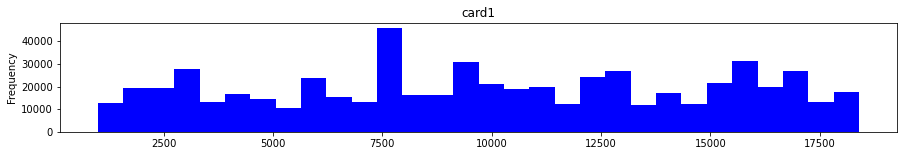

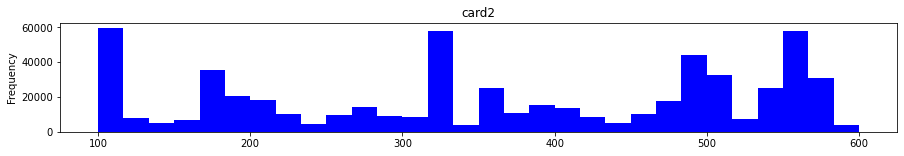

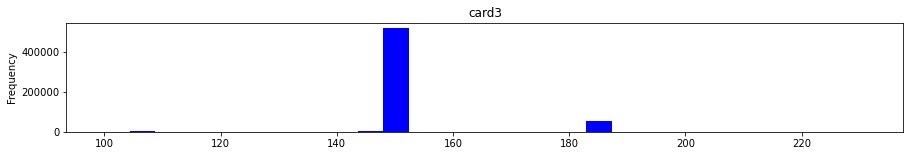

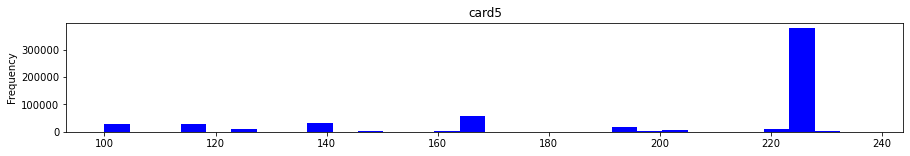

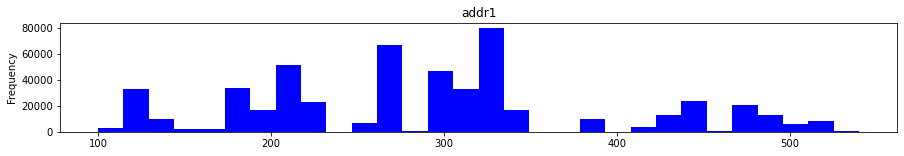

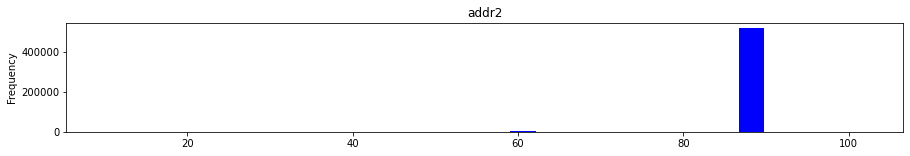

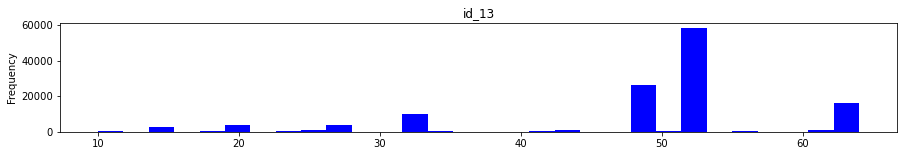

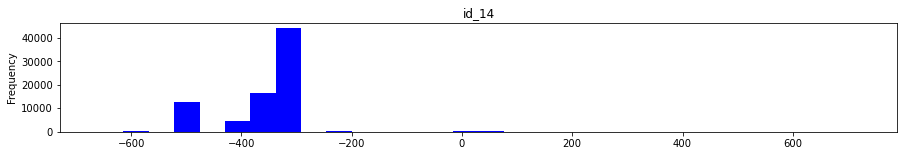

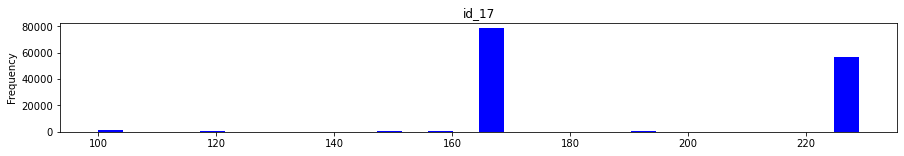

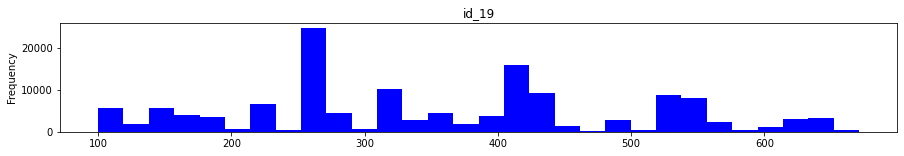

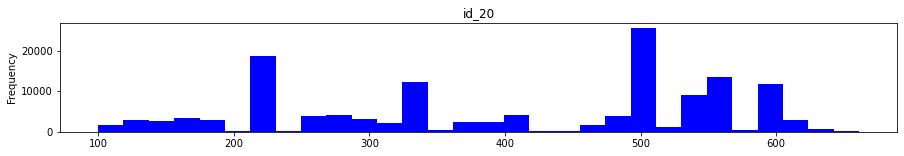

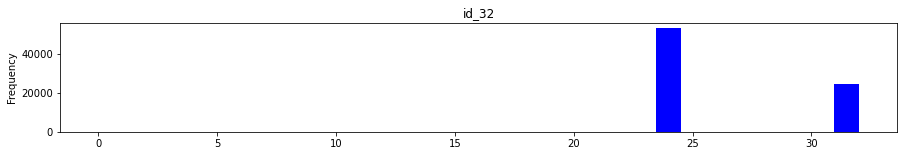

In [49]:
for i in cat_numbers: 
    X[i].plot(kind='hist',
                    bins=30,
                    title=i,      #looking at the distribution of card5
                    color='blue',
                    figsize = (15,2))
    plt.show()
    
### frequency encode these, too much values for OHE and there is most likely no internal ordering (its not indicated at least)

In [50]:
# Frequency encoding seems the most fruitful (as these plotted numeric values don't actually have a meaning and frequency of them does)
# However, this needs to be done on the splitted dataset to avoid dataleakage

x_train = X.iloc[:idx_train, :].copy(deep=True)
x_val = X.iloc[idx_train: idx_val, :].copy(deep=True)
x_test = X.iloc[-idx_test:, :].copy(deep=True)

# deep=True because later on it keeps giving me the 'trying to set a value to a copy of a slice is not possible'
# .loc / .iloc should fix this but it does not appear to work

In [52]:
print(x_train.shape, x_val.shape, x_test.shape) #jup looks good
# x_train.tail()

(413378, 204) (88581, 204) (88581, 204)


In [53]:
### DO THIS ON THE SPLITTED DATASET

for i in cat_numbers: 
    # we create the dictionary mapping value to count based on train, then apply it to train val and test
    temp = x_train[i].value_counts().to_dict()  #https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575
    string = i+'_counts'
    x_train.loc[:, string] = x_train[i].map(temp) #map onto a new column with name string

    placeholder = x_val[i].map(temp) #gives an 'see caveats' warning when doing it directly..
    x_val.loc[:, string] = placeholder 
    
    placeholder = x_test[i].map(temp)
    x_test.loc[:, string] = placeholder


In [54]:
print(cat_numbers)

['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_32']


In [55]:
# print(x_train[['card1', 'card1_counts']].value_counts())
x_val[['card1', 'card1_counts']].value_counts() #works. Note: these frequencies come from train 

card1  card1_counts
7919   10147.0         2361
9500   9680.0          2201
17188  7105.0          1655
15885  7543.0          1321
15066  5459.0          1224
                       ... 
12543  3.0                1
5014   4.0                1
5008   4.0                1
5002   8.0                1
1006   2.0                1
Length: 5635, dtype: int64

In [56]:
x_train.drop(columns=cat_numbers, inplace=True)
x_val.drop(columns=cat_numbers, inplace=True)
x_test.drop(columns=cat_numbers, inplace=True)

In [57]:
x_train

,TransactionAmt,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_15,id_16,...,DeviceCorp_MYA,DeviceCorp_Microsoft,DeviceCorp_OTHER,DeviceCorp_Others,DeviceCorp_PIXEL,DeviceCorp_PRA,DeviceCorp_REDMI,DeviceCorp_RV,DeviceCorp_SAMSUNG,DeviceCorp_SM,DeviceCorp_SONY,DeviceCorp_TA,DeviceCorp_TRIDENT/7.0,DeviceCorp_TRT,DeviceCorp_WAS,DeviceCorp_WINDOWS,DeviceCorp_XT1635,DeviceCorp_Yahoo,DeviceCorp_ZTE,DeviceCorp_anonymous.com,DeviceCorp_aol.com,DeviceCorp_att.net,DeviceCorp_bellsouth.net,DeviceCorp_charter.net,DeviceCorp_comcast.net,DeviceCorp_cox.net,DeviceCorp_earthlink.net,DeviceCorp_icloud.com,DeviceCorp_mail.com,DeviceCorp_me.com,DeviceCorp_missing_value,DeviceCorp_optonline.net,DeviceCorp_rocketmail.com,DeviceCorp_sbcglobal.net,DeviceCorp_verizon.net,DeviceCorp_ymail.com,DeviceCorp_nan,pixels,card1_counts,card2_counts,card3_counts,card5_counts,addr1_counts,addr2_counts,id_13_counts,id_14_counts,id_17_counts,id_19_counts,id_20_counts,id_32_counts
0,68.50,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,28,NaN,363155.0,175.0,15959.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN
1,29.00,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,522,2356.0,363155.0,19786.0,29730.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN
2,59.00,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,769,26051.0,363155.0,39248.0,17352.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN
3,50.00,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,2944,4285.0,363155.0,17469.0,6710.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN
4,50.00,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,2.0,0.0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2397600.0,9,10494.0,363155.0,19786.0,2483.0,362242.0,NaN,10543.0,62813.0,4221.0,550.0,20440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413373,47.94,NaN,8.0,5.0,0.0,0.0,1.0,5.0,0.0,0.0,3.0,0.0,4.0,0.0,9.0,6.0,0.0,NaN,0.0,207.0,207.0,NaN,NaN,NaN,0.0,34.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,791,31429.0,363155.0,207524.0,10738.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN
413374,226.00,3.0,15.0,17.0,0.0,0.0,9.0,16.0,0.0,0.0,10.0,0.0,12.0,0.0,55.0,11.0,183.0,119.0,0.0,208.0,0.0,NaN,NaN,NaN,213.0,208.0,NaN,NaN,NaN,213.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,

<AxesSubplot:xlabel='browser_id_31', ylabel='count'>

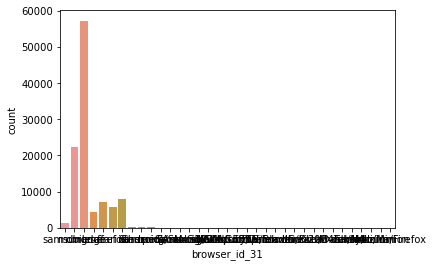

In [58]:
sns.countplot(data=x_train, x='browser_id_31')

In [59]:
for i in cat_others: 
    temp = x_train[i].value_counts().to_dict() 
    string = i+'_counts'
    x_train.loc[:, string] = x_train[i].map(temp) #map onto a new column with name string

    placeholder = x_val[i].map(temp) #gives an 'see caveats' warning when doing it directly..
    x_val.loc[:, string] = placeholder 
    
    placeholder = x_test[i].map(temp)
    x_test.loc[:, string] = placeholder

In [60]:
x_train.drop(columns=cat_others, inplace=True)
x_val.drop(columns=cat_others, inplace=True)
x_test.drop(columns=cat_others, inplace=True)

In [61]:
x_train.head()

,TransactionAmt,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_15,id_16,...,DeviceCorp_Others,DeviceCorp_PIXEL,DeviceCorp_PRA,DeviceCorp_REDMI,DeviceCorp_RV,DeviceCorp_SAMSUNG,DeviceCorp_SM,DeviceCorp_SONY,DeviceCorp_TA,DeviceCorp_TRIDENT/7.0,DeviceCorp_TRT,DeviceCorp_WAS,DeviceCorp_WINDOWS,DeviceCorp_XT1635,DeviceCorp_Yahoo,DeviceCorp_ZTE,DeviceCorp_anonymous.com,DeviceCorp_aol.com,DeviceCorp_att.net,DeviceCorp_bellsouth.net,DeviceCorp_charter.net,DeviceCorp_comcast.net,DeviceCorp_cox.net,DeviceCorp_earthlink.net,DeviceCorp_icloud.com,DeviceCorp_mail.com,DeviceCorp_me.com,DeviceCorp_missing_value,DeviceCorp_optonline.net,DeviceCorp_rocketmail.com,DeviceCorp_sbcglobal.net,DeviceCorp_verizon.net,DeviceCorp_ymail.com,DeviceCorp_nan,pixels,card1_counts,card2_counts,card3_counts,card5_counts,addr1_counts,addr2_counts,id_13_counts,id_14_counts,id_17_counts,id_19_counts,id_20_counts,id_32_counts,DeviceInfo_counts,browser_id_31_counts,version_id_31_counts
0,68.5,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,28,NaN,363155.0,175.0,15959.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,522,2356.0,363155.0,19786.0,29730.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,769,26051.0,363155.0,39248.0,17352.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.0,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,2944,4285.0,363155.0,17469.0,6710.0,362242.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,2.0,0.0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2397600.0,9,10494.0,363155.0,19786.0,2483.0,362242.0,NaN,10543.0,62813.0,4221.0,550.0,20440.0,9.0,1451.0,1054.0


In [62]:
# print proportion missing per column
# some have really high proprtion missing

for c in x_train.columns:
    miss_prop = x_train[c].isnull().sum() / len(x_train)
    if miss_prop > 0: 
        print(c, miss_prop)

num = ['dist1', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'pixels'] 

for i in range(1,16):
    if i==7:
        continue
    else:
        num.append('D'+str(i))

dist1 0.6187436196411032
D1 0.0006604125038100721
D2 0.49914122183570486
D3 0.4710676426902254
D4 0.2956495023924834
D5 0.5416108259268756
D6 0.8728282588817015
D8 0.8640783979795732
D9 0.8640783979795732
D10 0.14801465002975486
D11 0.5461659788377707
D12 0.8856034912356245
D13 0.8933832956761124
D14 0.8912182070647204
D15 0.16531842526694696
M1 0.5380426631315648
M2 0.5380426631315648
M3 0.5380426631315648
M5 0.6041564863151885
M6 0.31121878764714134
M7 0.6692059083937704
M8 0.6691962320200882
M9 0.6691962320200882
id_01 0.7341150230539603
id_02 0.7401143747369235
id_03 0.8810604337918322
id_04 0.8810604337918322
id_05 0.7469652473039203
id_06 0.7469652473039203
id_09 0.8640783979795732
id_10 0.8640783979795732
id_11 0.7398410171804015
id_12 0.7341150230539603
id_15 0.7398410171804015
id_16 0.7606694115313345
id_28 0.7398410171804015
id_29 0.7398410171804015
id_34 0.8503573000982152
id_35 0.7398410171804015
id_36 0.7398410171804015
id_37 0.7398410171804015
id_38 0.7398410171804015
ver

In [63]:
x_train[num] #numeric columns

,dist1,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,pixels,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15
0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,287.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,NaN,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,2397600.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,207.0,207.0,NaN,NaN,NaN,0.0,34.0,NaN,NaN,NaN,0.0
413374,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.0,119.0,0.0,208.0,0.0,NaN,NaN,NaN,213.0,208.0,NaN,NaN,NaN,213.0
413375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN,8.0,0.0,NaN,NaN,NaN,8.0
413376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0


In [64]:
x_train[num].shape
x_train[num].values

array([[ 19.,  nan,  nan, ...,  nan,  nan,   0.],
       [ nan,  nan,  nan, ...,  nan,  nan,   0.],
       [287.,  nan,  nan, ...,  nan,  nan, 315.],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,   8.],
       [ nan,  nan,  nan, ...,  nan,  nan,   0.],
       [  4.,  nan,  nan, ...,  nan,  nan, 247.]])

In [65]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(x_train[num].values) #.reshape(-1, 1))
x_train[num] = imputer.transform(x_train[num].values ) #if you want to do one column: add .reshape(-1, 1))

In [66]:
x_val[num] = imputer.transform(x_val[num].values ) 
x_test[num] = imputer.transform(x_test[num].values )

In [68]:
cat = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28',
              'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'version_id_30',  'version_id_31_counts',
              'card2_counts',  'card3_counts', 'card5_counts', 'addr1_counts', 'addr2_counts', 
              'id_13_counts', 'id_14_counts', 'id_17_counts', 'id_19_counts', 'id_20_counts', 
              'id_32_counts', 'DeviceInfo_counts', 'browser_id_31_counts' ] #categorical variables

In [69]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1) #all cats are +, so add this new category through using a negative number
imputer.fit(x_train[cat].values) 
x_train[cat] = imputer.transform(x_train[cat].values ) #if you want to do one column: add .reshape(-1, 1))
x_val[cat] = imputer.transform(x_val[cat].values ) 
x_test[cat] = imputer.transform(x_test[cat].values )

In [419]:
# x_train.drop(columns=['screen_width', 'screen_height'], inplace=True)
# x_val.drop(columns=['screen_width', 'screen_height'], inplace=True)
# x_test.drop(columns=['screen_width', 'screen_height'], inplace=True)

## Normalization

In [71]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()
Scaler.fit(x_train[x_train.columns].values)
x_train[x_train.columns] = Scaler.transform(x_train[x_train.columns].values)

In [72]:
x_val[x_val.columns] = Scaler.transform(x_val[x_val.columns].values)
x_test[x_val.columns] = Scaler.transform(x_test[x_test.columns].values)

In [73]:
x_train.head()

,TransactionAmt,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_15,id_16,...,DeviceCorp_Others,DeviceCorp_PIXEL,DeviceCorp_PRA,DeviceCorp_REDMI,DeviceCorp_RV,DeviceCorp_SAMSUNG,DeviceCorp_SM,DeviceCorp_SONY,DeviceCorp_TA,DeviceCorp_TRIDENT/7.0,DeviceCorp_TRT,DeviceCorp_WAS,DeviceCorp_WINDOWS,DeviceCorp_XT1635,DeviceCorp_Yahoo,DeviceCorp_ZTE,DeviceCorp_anonymous.com,DeviceCorp_aol.com,DeviceCorp_att.net,DeviceCorp_bellsouth.net,DeviceCorp_charter.net,DeviceCorp_comcast.net,DeviceCorp_cox.net,DeviceCorp_earthlink.net,DeviceCorp_icloud.com,DeviceCorp_mail.com,DeviceCorp_me.com,DeviceCorp_missing_value,DeviceCorp_optonline.net,DeviceCorp_rocketmail.com,DeviceCorp_sbcglobal.net,DeviceCorp_verizon.net,DeviceCorp_ymail.com,DeviceCorp_nan,pixels,card1_counts,card2_counts,card3_counts,card5_counts,addr1_counts,addr2_counts,id_13_counts,id_14_counts,id_17_counts,id_19_counts,id_20_counts,id_32_counts,DeviceInfo_counts,browser_id_31_counts,version_id_31_counts
0,0.002137,0.001846,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.004762,0.000000,0.000627,0.0,0.000343,0.0007,0.021875,0.258506,0.018868,0.271271,0.054665,0.161532,0.088288,0.585356,0.016010,0.099698,0.195856,0.021149,0.244971,0.092737,1.0,1.0,1.0,0.5,1.0,0.0,0.0,0.0,0.90163,0.167067,0.548495,0.998005,0.594841,0.934278,0.59195,0.997049,0.972888,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.057215,0.002661,0.000000,1.0,0.000848,0.484532,1.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000900,0.012167,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.000000,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.258506,0.041515,0.130621,0.054665,0.161532,0.088288,0.585356,0.000000,0.278539,0.195856,0.021149,0.244971,0.092737,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.90163,0.167067,0.548495,0.998005,0.594841,0.934278,0.59195,0.997049,0.972888,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.057215,0.051350,0.070053,1.0,0.095348,0.902608,1.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.001839,0.027891,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.000343,0.0007,0.000000,0.258506,0.041515,0.130621,0.054665,0.161532,0.088288,0.585356,0.000000,0.555891,0.195856,0.021149,0.244971,0.444693,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.90163,0.167067,0.548495,0.998005,0.594841,0.934278,0.59195,0.997049,0.972888,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.057215,0.075695,0.774297,1.0,0.189129,0.526822,1.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.001558,0.012167,0.000427,0.000878,0.0,0.0,0.0,0.001776,0.0,0.0000,0.004762,0.000000,0.000314,0.0,0.008568,0.0007,0.175000,0.175000,0.000000,0.231263,0.000000,0.161532,0.088288,0.585356,0.103448,0.278539,0.195856,0.021149,0.244971,0.216760,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.90163,0.167067,0.548495,0.998005,0.594841,0.934278,0.59195,0.997049,0.972888,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.057215,0.290065,0.127385,1.0,0.084183,0.203740,1.0,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.001558,0.012167,0.000213,0.000176,0.0,0.0,0.0,0.000444,0.0,0.0003,0.000000,0.000307,0.000314,0.0,0.000343,0.0007,0.000000,0.258506,0.041515,0.271271,0.054665,0.161532,0.088288,0.585356,0.141985,0.278539,0.195856,0.021149,0.244971,0.263324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.070788,0.548495,0.998005,0.594841,0.934278,0.59195,0.997049,1.000000,0.5,1.0,0.5,...,0.0,0.0,0.0,0.

In [74]:
for c in x_val.columns:
    miss_prop = x_val[c].isnull().sum() / len(x_val)
    if miss_prop > 0: 
        print(c, miss_prop)

for c in x_test.columns:
    miss_prop = x_test[c].isnull().sum() / len(x_test)
    if miss_prop > 0: 
        print(c, miss_prop)

## OK so card1 has no missing in train but it does have missing in val & test:
## we impute it with -1

x_val['card1_counts'] = x_val['card1_counts'].fillna(-1)
x_test['card1_counts'] = x_test['card1_counts'].fillna(-1)

card1_counts 0.010916562242467346
card1_counts 0.013659814181370723


## saving the final dfs

In [ ]:
x_train.to_csv('Data/ieee_x_train.csv', index=False)
x_val.to_csv('Data/ieee_x_val.csv', index=False)
x_test.to_csv('Data/ieee_x_test.csv', index=False)

y_train.to_csv('Data/ieee_y_train.csv', index=False)
y_val.to_csv('Data/ieee_y_val.csv', index=False)
y_test.to_csv('Data/ieee_y_test.csv', index=False)